# Персонализация предложений постоянным клиентам интернет-магазина
## Описание проекта
Заказчик интернет-магазин продаёт разные товары: для детей, для дома, мелкую бытовую технику, косметику и даже продукты. Отчёт магазина за прошлый период показал, что активность покупателей начала снижаться. Привлекать новых клиентов уже не так эффективно: о магазине и так знает большая часть целевой аудитории. Возможный выход — удерживать активность постоянных клиентов. Сделать это можно с помощью персонализированных предложений. Необходимо разработать модель, которая позволит персонализировать предложения постоянным клиентам, чтобы увеличить их покупательскую активность.
## План проекта:
1. Загрузить данные и проверить их соответствующему описанию
2. Провести предобработку данных
3. Провести исследовательский анализ данных
4. Объединить данные в единую таблицу
5. Провести кореляционный анализ данных
6. Обучить четыре модели  для персонализации предложений, с использованием Pipeline
7. Необхадимо провести оценку важности признаков для лучшей модели
8. Провести сегментацию, для выбронной группы покупателей

## Описание данных
* `market_file.csv` - Таблица, которая содержит данные о поведении покупателя на сайте, о коммуникациях с покупателем и его продуктовом поведении.
* `market_money.csv` - Таблица с данными о выручке, которую получает магазин с покупателя, то есть сколько покупатель всего потратил за период взаимодействия с сайтом.
* `market_time.csv` - Таблица с данными о времени (в минутах), которое покупатель провёл на сайте в течение периода.
* `money.csv` - Таблица с данными о среднемесячной прибыли продавца за последние 3 месяца: какую прибыль получает магазин от продаж каждому покупателю.

## Загрузка данных

1.1 Загрузите данные.

In [1]:
!pip install phik -q
!pip install --upgrade scikit-learn -q
!pip install shap -q
!pip install matplotlib==3.5.0 -q

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import phik
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import shap

# загружаем класс pipeline
from sklearn.pipeline import Pipeline

# загружаем классы для подготовки данных
from sklearn.preprocessing import (OneHotEncoder, OrdinalEncoder, StandardScaler,
                                   MinMaxScaler, RobustScaler, LabelEncoder)
from sklearn.compose import ColumnTransformer

# загружаем класс для работы с пропусками
from sklearn.impute import SimpleImputer

# загружаем функцию для работы с метриками
from sklearn.metrics import roc_auc_score, f1_score

# импортируем класс RandomizedSearchCV
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

# загружаем нужные модели
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC


RANDOM_STATE = 24
TEST_SIZE = 0.25

In [2]:
df_market_file = pd.read_csv('/datasets/market_file.csv')
df_market_money = pd.read_csv('/datasets/market_money.csv')
df_market_time = pd.read_csv('/datasets/market_time.csv')
df_money_mean = pd.read_csv('/datasets/money.csv', sep=';', decimal=',')

1.2 Проверьте, что данные в таблицах соответствуют описанию. Исследованием и объединением данных вы займётесь позже.

In [3]:
for i in [df_market_file, df_market_money, df_market_time, df_money_mean]:
    print('')
    for j in i.select_dtypes(exclude='number').columns:
        print(i[j].value_counts())
    
    display(i.select_dtypes(include='number').sample(5).T)
    print('')


,Прежний уровень    802
,Снизилась          498
,Name: Покупательская активность, dtype: int64
,стандарт     914
,премиум      376
,стандартт     10
,Name: Тип сервиса, dtype: int64
,да     962
,нет    338
,Name: Разрешить сообщать, dtype: int64
,Товары для детей                        330
,Домашний текстиль                       251
,Косметика и аксесуары                   223
,Техника для красоты и здоровья          184
,Мелкая бытовая техника и электроника    174
,Кухонная посуда                         138
,Name: Популярная_категория, dtype: int64


,1289,1170,1089,417,154
id,216637.00,216518.00,216437.00,215765.0,215502.00
Маркет_актив_6_мес,3.50,3.30,3.30,3.9,3.10
Маркет_актив_тек_мес,3.00,5.00,5.00,4.0,4.00
Длительность,801.00,994.00,517.00,388.0,342.00
Акционные_покупки,0.22,0.28,0.25,0.6,0.98
Средний_просмотр_категорий_за_визит,5.00,4.00,1.00,4.0,2.00
Неоплаченные_продукты_штук_квартал,1.00,3.00,2.00,0.0,7.00
Ошибка_сервиса,4.00,5.00,1.00,4.0,5.00
Страниц_за_визит,6.00,10.00,9.00,8.0,3.00



,
,предыдущий_месяц       1300
,препредыдущий_месяц    1300
,текущий_месяц          1300
,Name: Период, dtype: int64


,198,654,134,1134,2959
id,215414.0,215566.0,215392.0,215726.0,216334.0
Выручка,4747.0,4702.0,4548.0,5894.5,4767.5



,
,предыдцщий_месяц    1300
,текущий_месяц       1300
,Name: Период, dtype: int64


,2472,62,850,2418,528
id,216584,215379,215773,216557,215612
минут,20,10,13,10,12



,


,425,1170,533,132,435
id,215773.00,216518.00,215881.00,215480.00,215783.0
Прибыль,3.74,4.22,2.53,4.04,5.6


**Вывод:**

Данные в таблицах соответствуют описанию. Для чтения файла `df_money_mean` в качестве разделителя выступал знак (`;`), сами данные в качестве десятичного разделителя были записаны со знаком (`,`).

## Предобработка данных
Проведите необходимую предобработку данных. Названия столбцов можно оставить кириллическими.

### Приведение колонок в змеиный регистр и проверка на пропуски и дубли

In [4]:
# Функиця для приведения колонок в змеиный регистр, приведение в нижний регистр кат. значений
# и проверка на пропуски и дубли
def norm_columns(file):
    file.columns = file.columns.str.replace(' ', '_').str.lower()
    for i in file.select_dtypes(exclude='number').columns:
        print('Было \n', file[i].unique())
        file[i] = file[i].str.replace(' ', '_').str.lower()
        print('Стало \n', file[i].unique())
        print()
    print('Количество пропусков', file.isna().sum().sum())
    print('Количество дубликатов', file.duplicated().sum(), 5*'\n')

for _ in [df_market_file, df_market_money, df_market_time, df_money_mean]:
    print(_.info())
    norm_columns(_)
    

<class 'pandas.core.frame.DataFrame'>
,RangeIndex: 1300 entries, 0 to 1299
,Data columns (total 13 columns):
, #   Column                               Non-Null Count  Dtype  
,---  ------                               --------------  -----  
, 0   id                                   1300 non-null   int64  
, 1   Покупательская активность            1300 non-null   object 
, 2   Тип сервиса                          1300 non-null   object 
, 3   Разрешить сообщать                   1300 non-null   object 
, 4   Маркет_актив_6_мес                   1300 non-null   float64
, 5   Маркет_актив_тек_мес                 1300 non-null   int64  
, 6   Длительность                         1300 non-null   int64  
, 7   Акционные_покупки                    1300 non-null   float64
, 8   Популярная_категория                 1300 non-null   object 
, 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
, 10  Неоплаченные_продукты_штук_квартал   1300 non-null   int64  
, 11  Ошибка_сервиса

### Проверка типов данных для df_market_money

In [5]:
# Проверка типов данных для df_market_file
df_market_file.info()
display(df_market_file.sample(3).T)

<class 'pandas.core.frame.DataFrame'>
,RangeIndex: 1300 entries, 0 to 1299
,Data columns (total 13 columns):
, #   Column                               Non-Null Count  Dtype  
,---  ------                               --------------  -----  
, 0   id                                   1300 non-null   int64  
, 1   покупательская_активность            1300 non-null   object 
, 2   тип_сервиса                          1300 non-null   object 
, 3   разрешить_сообщать                   1300 non-null   object 
, 4   маркет_актив_6_мес                   1300 non-null   float64
, 5   маркет_актив_тек_мес                 1300 non-null   int64  
, 6   длительность                         1300 non-null   int64  
, 7   акционные_покупки                    1300 non-null   float64
, 8   популярная_категория                 1300 non-null   object 
, 9   средний_просмотр_категорий_за_визит  1300 non-null   int64  
, 10  неоплаченные_продукты_штук_квартал   1300 non-null   int64  
, 11  ошибка_сервиса

,388,543,104
id,215736,215891,215452
покупательская_активность,снизилась,прежний_уровень,снизилась
тип_сервиса,премиум,стандарт,стандарт
разрешить_сообщать,да,да,да
маркет_актив_6_мес,5.6,4.8,3.8
маркет_актив_тек_мес,3,4,4
длительность,540,795,756
акционные_покупки,0.36,0.21,0.9
популярная_категория,косметика_и_аксесуары,домашний_текстиль,товары_для_детей
средний_просмотр_категорий_за_визит,2,4,2


In [6]:
# Проверка типов данных для df_market_money
df_market_money.info()
display(df_market_money.sample(3).T)

<class 'pandas.core.frame.DataFrame'>
,RangeIndex: 3900 entries, 0 to 3899
,Data columns (total 3 columns):
, #   Column   Non-Null Count  Dtype  
,---  ------   --------------  -----  
, 0   id       3900 non-null   int64  
, 1   период   3900 non-null   object 
, 2   выручка  3900 non-null   float64
,dtypes: float64(1), int64(1), object(1)
,memory usage: 91.5+ KB


,3685,2218,2978
id,216576,216087,216340
период,препредыдущий_месяц,текущий_месяц,текущий_месяц
выручка,5150.0,5084.1,4984.0


In [7]:
# Проверка типов данных для df_market_time
df_market_time.info()
display(df_market_time.sample(3).T)

<class 'pandas.core.frame.DataFrame'>
,RangeIndex: 2600 entries, 0 to 2599
,Data columns (total 3 columns):
, #   Column  Non-Null Count  Dtype 
,---  ------  --------------  ----- 
, 0   id      2600 non-null   int64 
, 1   период  2600 non-null   object
, 2   минут   2600 non-null   int64 
,dtypes: int64(2), object(1)
,memory usage: 61.1+ KB


,20,1661,2551
id,215358,216178,216623
период,предыдцщий_месяц,предыдцщий_месяц,текущий_месяц
минут,14,19,17


In [8]:
# Проверка типов данных для df_money_mean
df_money_mean.info()
display(df_money_mean.sample(3).T)

<class 'pandas.core.frame.DataFrame'>
,RangeIndex: 1300 entries, 0 to 1299
,Data columns (total 2 columns):
, #   Column   Non-Null Count  Dtype  
,---  ------   --------------  -----  
, 0   id       1300 non-null   int64  
, 1   прибыль  1300 non-null   float64
,dtypes: float64(1), int64(1)
,memory usage: 20.4 KB


,196,922,407
id,215544.00,216270.00,215755.00
прибыль,3.84,3.17,3.35


### Замена ошибочных значений в категориальных данных

In [9]:
# Файл df_market_file
for i in df_market_file.select_dtypes(exclude='number').columns:
        print(df_market_file[i].value_counts(), '\n')
df_market_file['тип_сервиса'].replace('стандартт', 'стандарт', inplace=True)

прежний_уровень    802
,снизилась          498
,Name: покупательская_активность, dtype: int64 
,
,стандарт     914
,премиум      376
,стандартт     10
,Name: тип_сервиса, dtype: int64 
,
,да     962
,нет    338
,Name: разрешить_сообщать, dtype: int64 
,
,товары_для_детей                        330
,домашний_текстиль                       251
,косметика_и_аксесуары                   223
,техника_для_красоты_и_здоровья          184
,мелкая_бытовая_техника_и_электроника    174
,кухонная_посуда                         138
,Name: популярная_категория, dtype: int64 
,


In [10]:
# Файл df_market_money
for i in df_market_money.select_dtypes(exclude='number').columns:
        print(df_market_money[i].value_counts(), '\n')

предыдущий_месяц       1300
,препредыдущий_месяц    1300
,текущий_месяц          1300
,Name: период, dtype: int64 
,


In [11]:
# Файл df_market_time
for i in df_market_time.select_dtypes(exclude='number').columns:
        print(df_market_time[i].value_counts(), '\n')
df_market_time['период'].replace('предыдцщий_месяц', 'предыдущий_месяц', inplace=True)

предыдцщий_месяц    1300
,текущий_месяц       1300
,Name: период, dtype: int64 
,


In [12]:
for _ in [df_market_file, df_market_money, df_market_time, df_money_mean]:
    print('Количество пропусков', _.isna().sum().sum())
    print('Количество дубликатов', _.duplicated().sum(), '\n')

Количество пропусков 0
,Количество дубликатов 0 
,
,Количество пропусков 0
,Количество дубликатов 0 
,
,Количество пропусков 0
,Количество дубликатов 0 
,
,Количество пропусков 0
,Количество дубликатов 0 
,


**Вывод:**

* Во всех файлах колонки были приведены в змеиный регистр
* Во всех файлах категориальные данные были приведены в нижний регистр, разделительный знак выбран ( _ )
* Неправильые категориальные значения были исправлены
* Количество пропусков и дубликатов 0
* Все данные соответствуют своему типу данных

## Исследовательский анализ данных

Проведите исследовательский анализ данных из каждой таблицы. Отберите клиентов с покупательской активностью не менее трёх месяцев, то есть таких, которые что-либо покупали в этот период. Оформите выводы по результатам шага.

In [13]:
#df_market_file, df_market_money, df_market_time, df_money_mean

In [14]:
# Отберите клиентов с покупательской активностью не менее трёх месяцев, те. стоит выбрать те id 
# где за все 3 месяца выручка больше 0
print(df_market_money.query('выручка == 0'))
print(df_market_money.query('выручка == 0')['id'].unique())

df_market_file = df_market_file.query('id != [215348, 215357, 215359]')
df_market_money = df_market_money.query('id != [215348, 215357, 215359]')
df_market_time = df_market_time.query('id != [215348, 215357, 215359]')
df_money_mean = df_money_mean.query('id != [215348, 215357, 215359]')

        id               период  выручка
,0   215348  препредыдущий_месяц      0.0
,2   215348     предыдущий_месяц      0.0
,28  215357  препредыдущий_месяц      0.0
,29  215357     предыдущий_месяц      0.0
,34  215359     предыдущий_месяц      0.0
,35  215359  препредыдущий_месяц      0.0
,[215348 215357 215359]


In [15]:
df_market_file.sample(5)

,id,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит
416,215764,прежний_уровень,стандарт,да,4.0,4,539,0.11,косметика_и_аксесуары,2,2,5,7
38,215386,снизилась,стандарт,да,1.5,3,495,0.98,домашний_текстиль,2,3,7,5
327,215675,снизилась,стандарт,да,5.5,5,726,0.16,товары_для_детей,4,5,7,5
784,216132,прежний_уровень,стандарт,да,5.5,5,718,0.15,мелкая_бытовая_техника_и_электроника,6,1,5,6
967,216315,прежний_уровень,стандарт,да,4.3,5,211,0.23,косметика_и_аксесуары,1,1,5,6


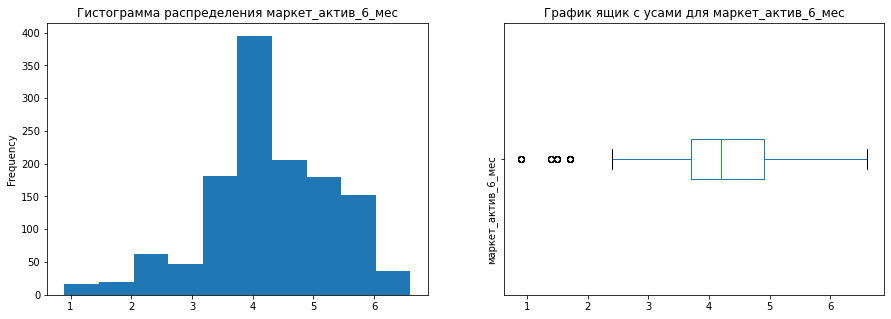

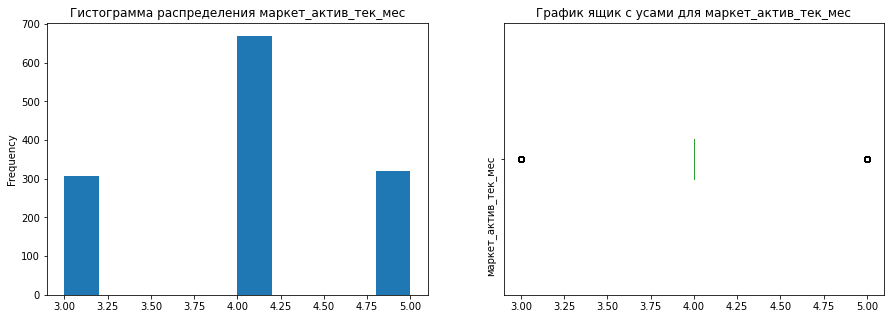

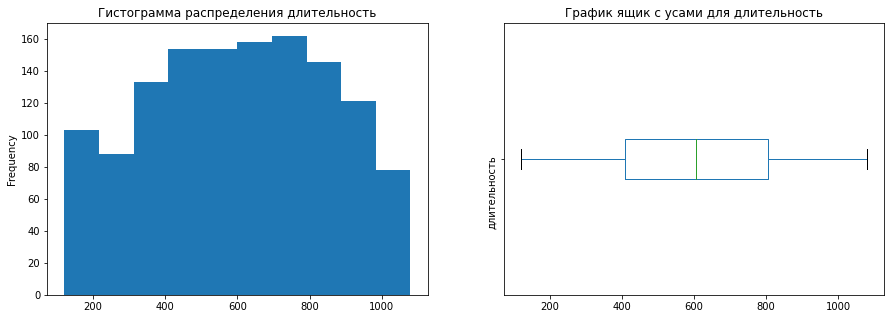

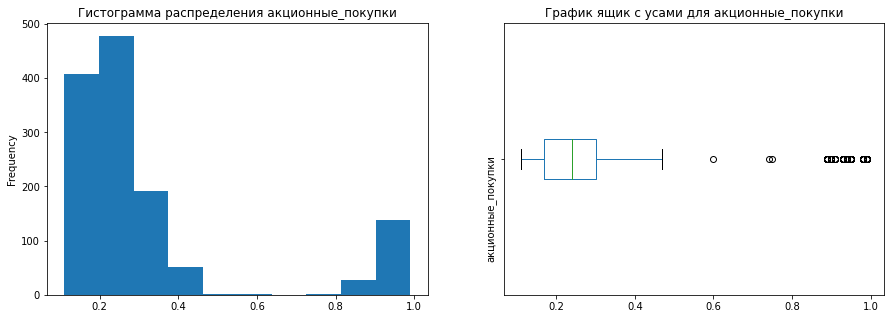

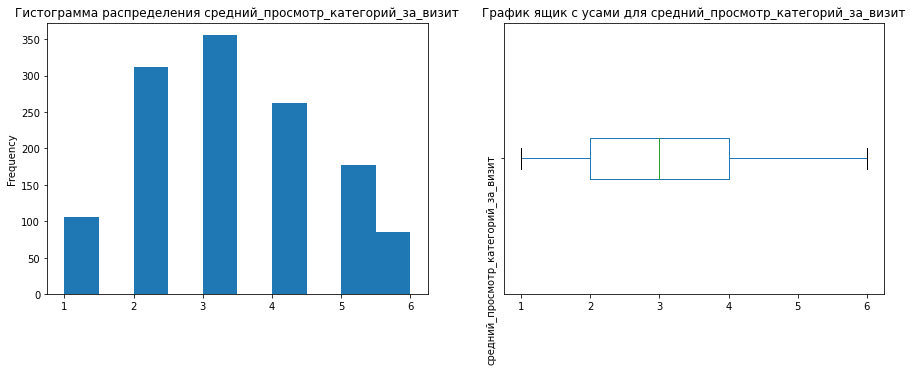

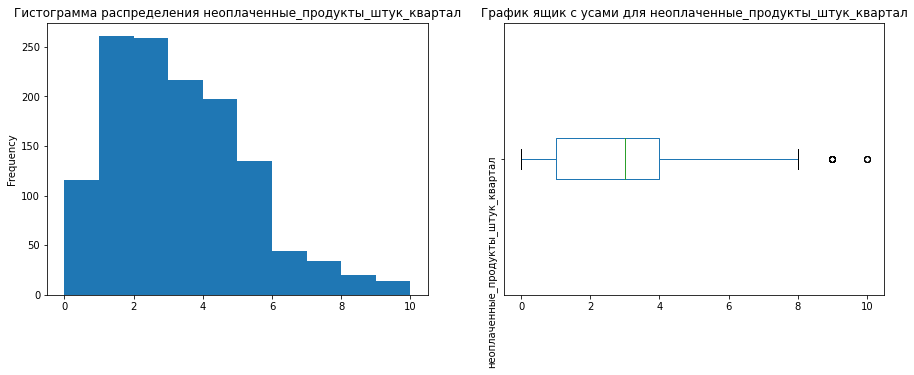

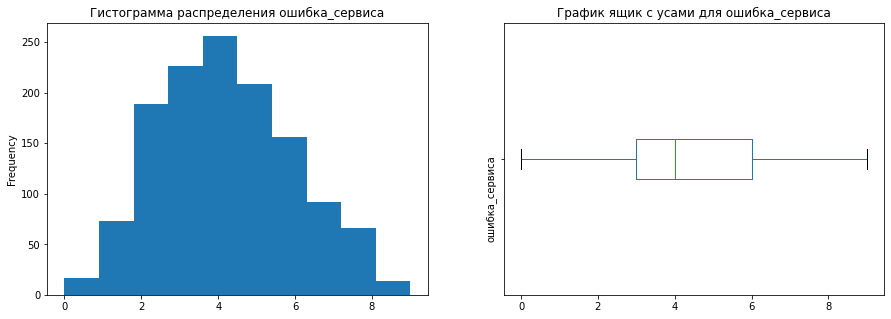

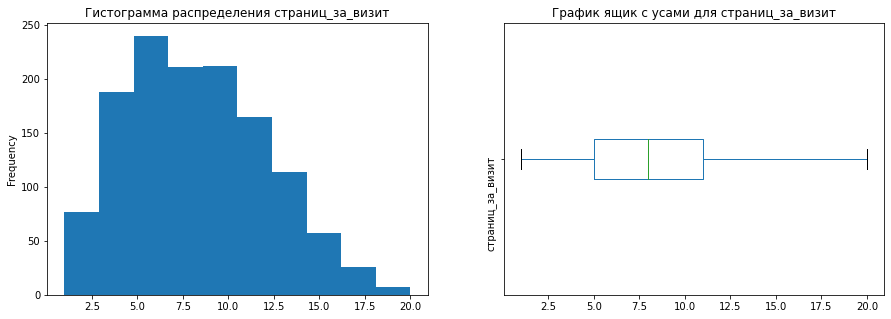

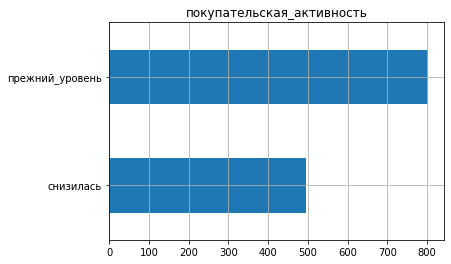

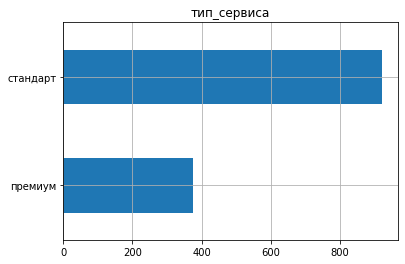

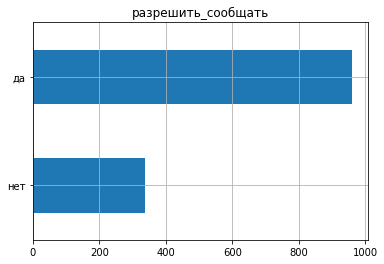

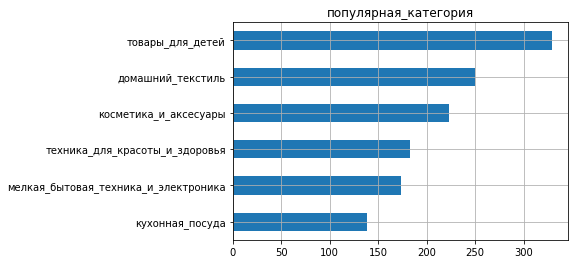

In [16]:
def hist_box_bar(file):
    
    for i in file.select_dtypes(include='number').columns:
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5))

        file[i].plot(kind='hist', ax=axes[0])
        axes[0].set_title(f'Гистограмма распределения {i}')

        file[i].plot(kind='box', vert=False, ax=axes[1], rot=90)
        axes[1].set_title(f'График ящик с усами для {i}')
        plt.show()
    
    
    for i in file.select_dtypes(exclude='number').columns:
        file[i].value_counts(ascending=True).plot(kind='barh', rot=0, grid=True)
        plt.title(i)
        plt.show()

hist_box_bar(df_market_file.drop('id',1))

**Вывод:**

* Медианное значение маркет актив 6 мес. состовляет 4
* Гистограмма распределения акционных покупок представленно бимодальным распределением, тк некоторые пользователи покупают товапры только по акции
* Целевой признак покупательская активность представлен несбалансированным, прежний уровень преобладает в большей части. При использовании accuracy, иетрика покажет слишком оптимистические значения 
* Наиболее популярная категория это товары для детей

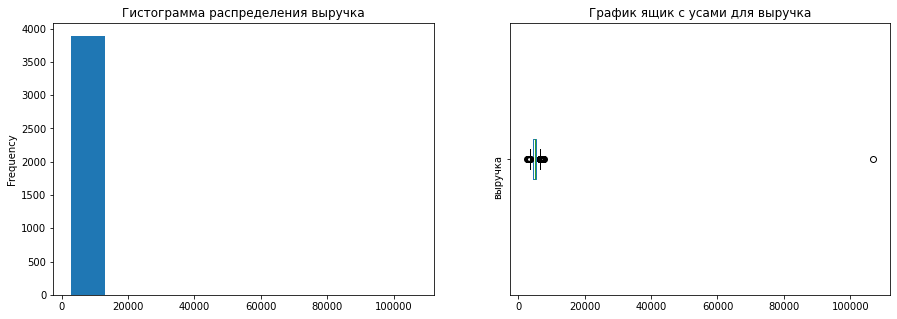

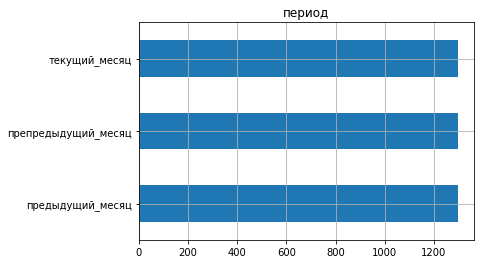

In [17]:
hist_box_bar(df_market_money.drop('id',1))

In [18]:
display(df_market_money.query('выручка > 8000'))
display(df_market_file.query('id == 215380'))
df_market_money.describe()

,id,период,выручка
98,215380,текущий_месяц,106862.2


,id,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит
32,215380,снизилась,премиум,нет,1.7,4,637,0.94,техника_для_красоты_и_здоровья,3,2,4,7


,id,выручка
count,3891.000000,3891.000000
mean,215998.986893,5033.718890
std,374.482249,1768.471286
min,215349.000000,2758.700000
25%,215675.000000,4592.000000
50%,215999.000000,4959.000000
75%,216323.000000,5363.200000
max,216647.000000,106862.200000


In [19]:
df_market_money.loc[df_market_money['выручка']>10000, 'выручка'] = df_market_money['выручка'].median()
df_market_money.query('id == 215380')

,id,период,выручка
96,215380,препредыдущий_месяц,5051.0
97,215380,предыдущий_месяц,6077.0
98,215380,текущий_месяц,4959.0


**Вывод:**
* Диаграмма распределения выручки показала, что медианное значение составляет 4959.0
* Среднее значение выручки состовляет 5033.7

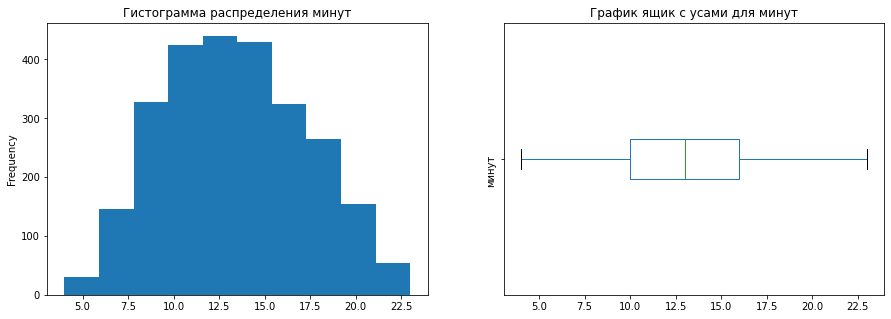

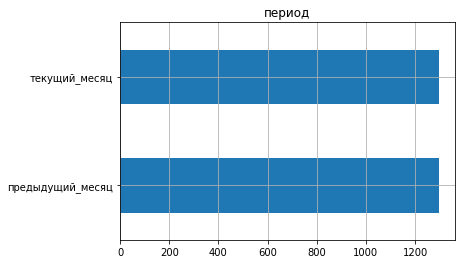

In [20]:
hist_box_bar(df_market_time.drop('id',1))

**Вывод:**
* В среднем пользователь находится на сайте от 10 до 16 минут
* Медианное значение нахождения на сайте, состовляет 13 минут

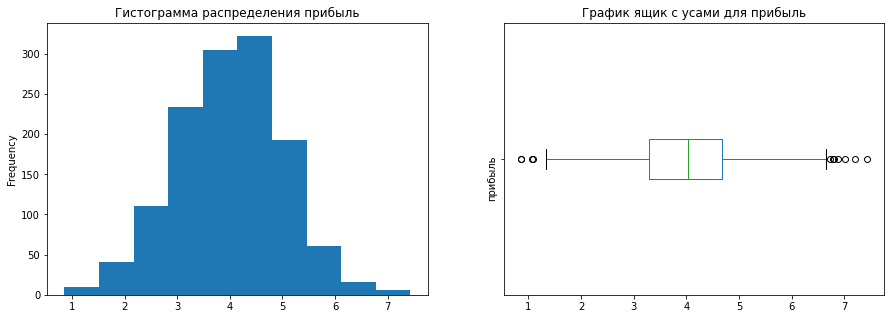

In [21]:
hist_box_bar(df_money_mean.drop('id',1))

**Вывод:**
* Среднемесячная прибыль с покупателя за последние 3 месяца состовялет от 3 до 5
* Медианная среднемесячная прибыль состовляет 4

## Объединение таблиц
 Объедините таблицы market_file.csv, market_money.csv, market_time.csv. 
 
 Учитывайте, что данные о выручке и времени на сайте находятся в одном столбце для всех периодов. В итоговой таблице сделайте отдельный столбец для каждого периода.
 

In [22]:
df_market_money = df_market_money.pivot_table(index='id', columns="период").reset_index()
df_market_money.columns = ['id', 'выручка_предыдущий_месяц', 'выручка_препредыдущий_месяц', 'выручка_текущий_месяц']
df_market_money

,id,выручка_предыдущий_месяц,выручка_препредыдущий_месяц,выручка_текущий_месяц
0,215349,5216.0,4472.0,4971.6
1,215350,5457.5,4826.0,5058.4
2,215351,6158.0,4793.0,6610.4
3,215352,5807.5,4594.0,5872.5
4,215353,4738.5,5124.0,5388.5
...,...,...,...,...
1292,216643,3664.0,4704.0,4741.7
1293,216644,4729.0,5299.0,5353.0
1294,216645,5160.0,5334.0,5139.2
1295,216646,4923.0,4725.0,5224.6


In [23]:
df_market_time = df_market_time.pivot_table(index='id', columns="период").reset_index()
df_market_time.columns = ['id', 'минут_предыдущий_месяц', 'минут_текущий_месяц']
df_market_time

,id,минут_предыдущий_месяц,минут_текущий_месяц
0,215349,12,10
1,215350,8,13
2,215351,11,13
3,215352,8,11
4,215353,10,10
...,...,...,...
1292,216643,14,7
1293,216644,12,11
1294,216645,12,18
1295,216646,18,7


In [24]:
df = df_market_file.merge(df_market_money, on='id')
df = df.merge(df_market_time, on='id')
print(df.isna().sum())
df.sample(5)

id                                     0
,покупательская_активность              0
,тип_сервиса                            0
,разрешить_сообщать                     0
,маркет_актив_6_мес                     0
,маркет_актив_тек_мес                   0
,длительность                           0
,акционные_покупки                      0
,популярная_категория                   0
,средний_просмотр_категорий_за_визит    0
,неоплаченные_продукты_штук_квартал     0
,ошибка_сервиса                         0
,страниц_за_визит                       0
,выручка_предыдущий_месяц               0
,выручка_препредыдущий_месяц            0
,выручка_текущий_месяц                  0
,минут_предыдущий_месяц                 0
,минут_текущий_месяц                    0
,dtype: int64


,id,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,выручка_предыдущий_месяц,выручка_препредыдущий_месяц,выручка_текущий_месяц,минут_предыдущий_месяц,минут_текущий_месяц
1120,216471,прежний_уровень,премиум,да,3.9,4,1042,0.25,товары_для_детей,2,1,6,10,3673.0,4661.0,4659.7,17,17
1018,216369,прежний_уровень,стандарт,да,4.3,4,779,0.25,мелкая_бытовая_техника_и_электроника,3,3,8,4,3980.0,4484.0,3673.2,16,17
1046,216397,прежний_уровень,стандарт,да,4.2,5,199,0.94,товары_для_детей,4,2,6,4,3846.0,4471.0,4518.1,14,11
730,216081,прежний_уровень,стандарт,нет,5.3,4,527,0.30,домашний_текстиль,5,2,4,10,4486.0,5122.0,4064.8,18,10
524,215875,прежний_уровень,стандарт,нет,4.7,4,203,0.28,косметика_и_аксесуары,3,2,6,10,4651.5,5139.0,4359.0,9,18


**Вывод:**
* Были созданы сводные таблицы для df_market_money, df_market_time, и после были объеденены с df_market_file по id
* После объединения итоговая таблица не показала пропущенных значений

## Корреляционный анализ

Проведите корреляционный анализ признаков в количественной шкале в итоговой таблице для моделирования. Сделайте выводы о мультиколлинеарности и при необходимости устраните её.

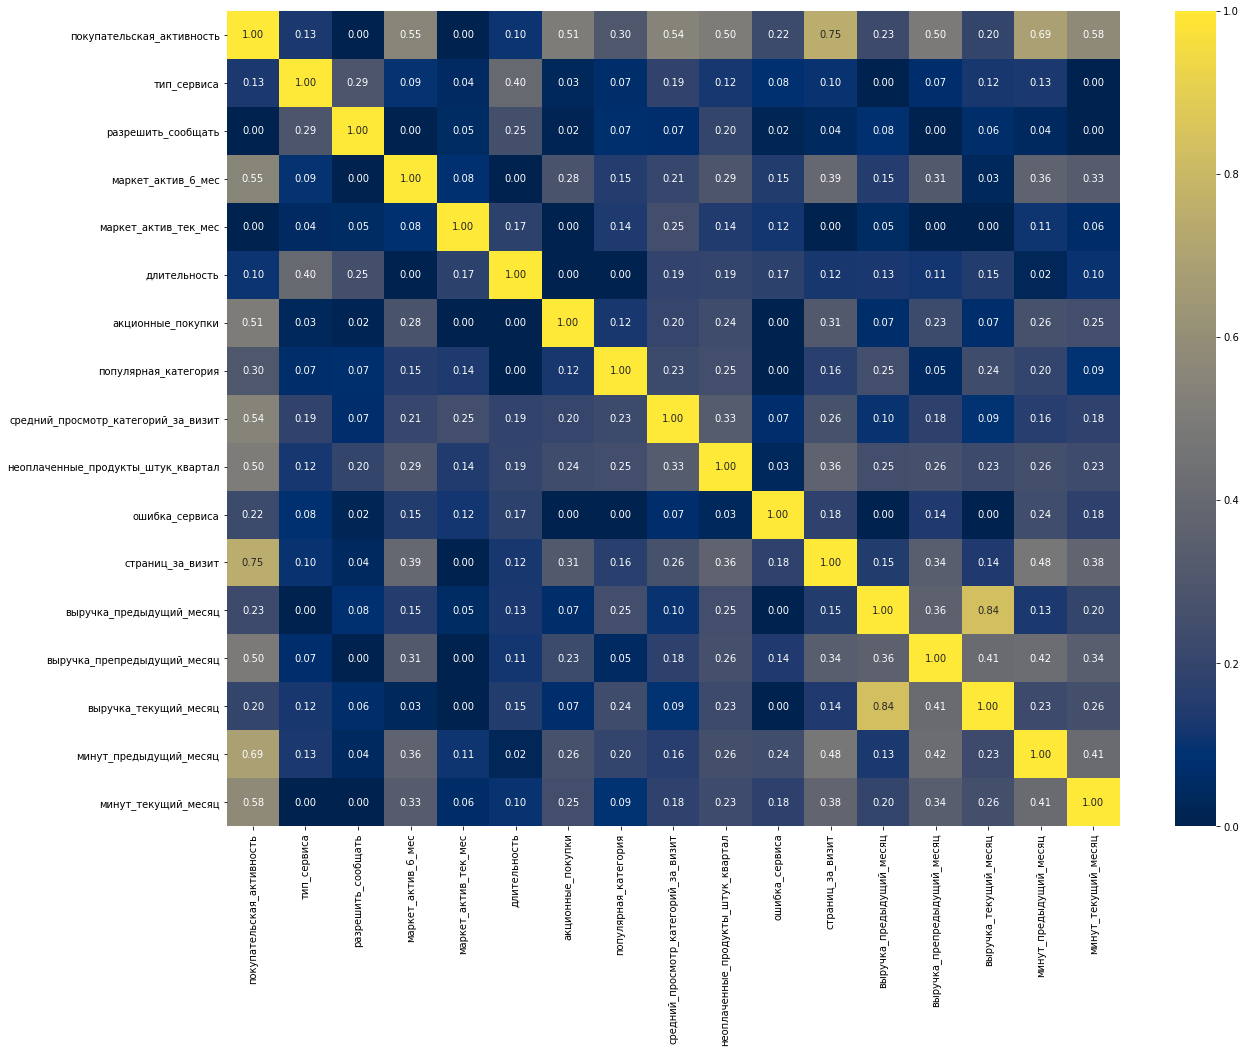

In [25]:
plt.figure(figsize=(20,15))
sns.heatmap(df.drop('id', 1).phik_matrix(
    interval_cols=df.select_dtypes(include='number').columns.tolist()),
            annot=True, fmt='.2f', cmap='cividis')
plt.show()

**Вывод:**
* Целевой признак больше всего корелирует с страниц_за_визит, кореляция состовляет 0.75
* Мультиколлинеарности между входными признаками не наблюдается

## Использование пайплайнов

Во время подготовки данных используйте ColumnTransformer. Количественные и категориальные признаки обработайте в пайплайне раздельно. Для кодирования категориальных признаков используйте как минимум два кодировщика, для масштабирования количественных — как минимум два скейлера.

Обучите четыре модели: KNeighborsClassifier(), DecisionTreeClassifier(), LogisticRegression() и  SVC(). Для каждой из них подберите как минимум один гиперпараметр. Выберите подходящую для задачи метрику, аргументируйте свой выбор. Используйте эту метрику при подборе гиперпараметров.

Выберите лучшую модель, используя заданную метрику. Для этого примените одну из стратегий:
* использовать пайплайны и инструменты подбора гиперпараметров для каждой модели отдельно, чтобы выбрать лучшую модель самостоятельно;
* использовать один общий пайплайн для всех моделей и инструмент подбора гиперпараметров, который вернёт вам лучшую модель.

In [26]:
for i in df.select_dtypes(exclude='number').columns:
        print(df[i].value_counts(), '\n')

прежний_уровень    802
,снизилась          495
,Name: покупательская_активность, dtype: int64 
,
,стандарт    922
,премиум     375
,Name: тип_сервиса, dtype: int64 
,
,да     959
,нет    338
,Name: разрешить_сообщать, dtype: int64 
,
,товары_для_детей                        329
,домашний_текстиль                       250
,косметика_и_аксесуары                   223
,техника_для_красоты_и_здоровья          183
,мелкая_бытовая_техника_и_электроника    174
,кухонная_посуда                         138
,Name: популярная_категория, dtype: int64 
,


In [27]:
print(df['покупательская_активность'].head())
le = LabelEncoder()
df['покупательская_активность'] = le.fit_transform(df['покупательская_активность'])
print(df['покупательская_активность'].head())

0    снизилась
,1    снизилась
,2    снизилась
,3    снизилась
,4    снизилась
,Name: покупательская_активность, dtype: object
,0    1
,1    1
,2    1
,3    1
,4    1
,Name: покупательская_активность, dtype: int64


In [28]:
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(['покупательская_активность', 'id'], axis=1),
    df['покупательская_активность'],
    test_size = TEST_SIZE, 
    random_state = RANDOM_STATE,
    stratify = df['покупательская_активность'])
X_proba = X_test.copy()
X_train.shape, X_test.shape

((972, 16), (325, 16))

In [29]:
X_test.sample(5)

,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,выручка_предыдущий_месяц,выручка_препредыдущий_месяц,выручка_текущий_месяц,минут_предыдущий_месяц,минут_текущий_месяц
1004,стандарт,да,5.1,4,433,0.14,товары_для_детей,4,1,4,9,4005.0,4768.0,4796.7,20,5
436,стандарт,да,5.3,4,808,0.23,косметика_и_аксесуары,3,0,5,7,5282.0,5261.0,5430.2,13,14
1048,стандарт,да,3.8,4,265,0.95,техника_для_красоты_и_здоровья,5,2,1,12,4728.0,5223.0,5285.7,15,9
670,премиум,нет,3.9,4,485,0.28,техника_для_красоты_и_здоровья,2,0,5,12,4143.0,4660.0,4721.5,16,8
690,стандарт,нет,2.6,4,498,0.16,мелкая_бытовая_техника_и_электроника,3,4,1,10,5277.5,4637.0,5962.6,13,8


In [30]:
# Для кодирования бинарных признаков исп. ohe
ohe_columns = ['разрешить_сообщать', 'популярная_категория']
ord_columns = ['тип_сервиса']
num_columns = df.drop(['покупательская_активность', 'id'],1).select_dtypes(include='number').columns.tolist()


In [31]:
# Pipleline
ohe_pipe = Pipeline([
        ('simpleImputer', 
         SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        ('ohe', 
         OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)
        )
    ])

ord_pipe = Pipeline(
    [
        (
            'simple_imputer_ord_before',
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ord',
            OrdinalEncoder(categories=[
                                      ['стандарт','премиум']],
                          handle_unknown='use_encoded_value',
                          unknown_value=np.nan)
        ),
        (
            'simple_imputer_ord_after',
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        )
    ]
)


data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_columns),
        ('ord', ord_pipe, ord_columns),
        ('num', StandardScaler(), num_columns)
    ], 
    remainder='passthrough'
)


pipe_final = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
    ]
) 


In [32]:
# Pipeline для выбора лучшей модели
param_grid = [
    # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 5),
        'models__max_features': range(2, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    
    # словарь для модели KNeighborsClassifier() 
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']   
    },

    # словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE, 
            solver='liblinear', 
            penalty='l1'
        )],
        'models__C': range(1, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    # словарь для модели SVC()
    {
        'models':[SVC(random_state=RANDOM_STATE, probability=True)],
        'models__kernel': ['rbf', 'linear', 'poly', 'sigmoid'],

        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    }
]

In [33]:
randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1
)

In [34]:
randomized_search.fit(X_train, y_train)

print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print ('Метрика лучшей модели на тренировочной выборке:', randomized_search.best_score_)

y_test_pred = randomized_search.predict_proba(X_test)
print(f'Метрика ROC-AUC на тестовой выборке: {roc_auc_score(y_test, y_test_pred[:,1])}')

Лучшая модель и её параметры:
,
, Pipeline(steps=[('preprocessor',
,                 ColumnTransformer(remainder='passthrough',
,                                   transformers=[('ohe',
,                                                  Pipeline(steps=[('simpleImputer',
,                                                                   SimpleImputer(strategy='most_frequent')),
,                                                                  ('ohe',
,                                                                   OneHotEncoder(drop='first',
,                                                                                 handle_unknown='ignore',
,                                                                                 sparse_output=False))]),
,                                                  ['разрешить_сообщать',
,                                                   'популярная_категория']),
,                                                 ('ord',
,                       

**Вывод:**
* Наилучшую точность получила модель SVC с коэфициентом  С=3
* Точность модели на тренировочной выборке 90%
* Точность модели на тестовой выборке 92%

## Анализ важности признаков
Оцените важность признаков для лучшей модели и постройте график важности с помощью метода SHAP.

In [35]:
#model = randomized_search.best_estimator_['models']
X_train_new = pipe_final.named_steps['preprocessor'].fit_transform(X_train)
X_test_new = pipe_final.named_steps['preprocessor'].transform(X_test)
feature_names = pipe_final.named_steps['preprocessor'].get_feature_names_out()
X_test_new = pd.DataFrame(X_test_new, columns=feature_names)

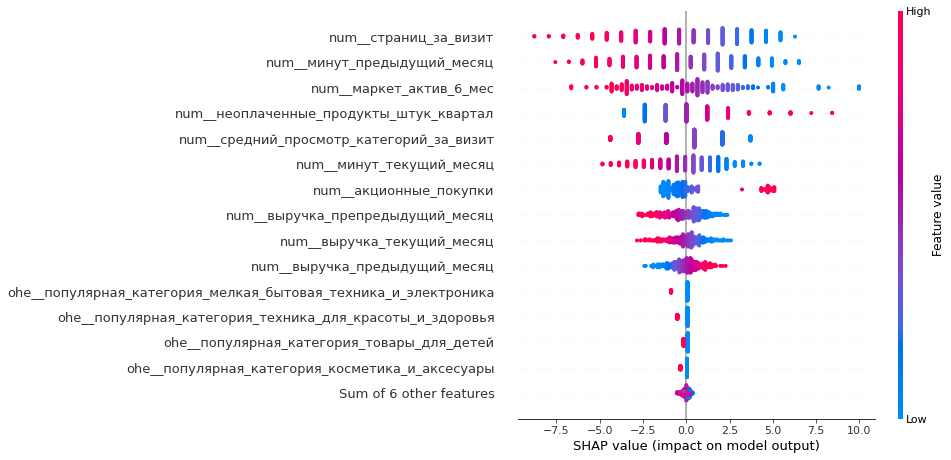

In [36]:
explainer = shap.LinearExplainer(randomized_search.best_estimator_['models'], X_test_new)
shap_values = explainer(X_test_new)
shap.plots.beeswarm(shap_values, max_display=15)

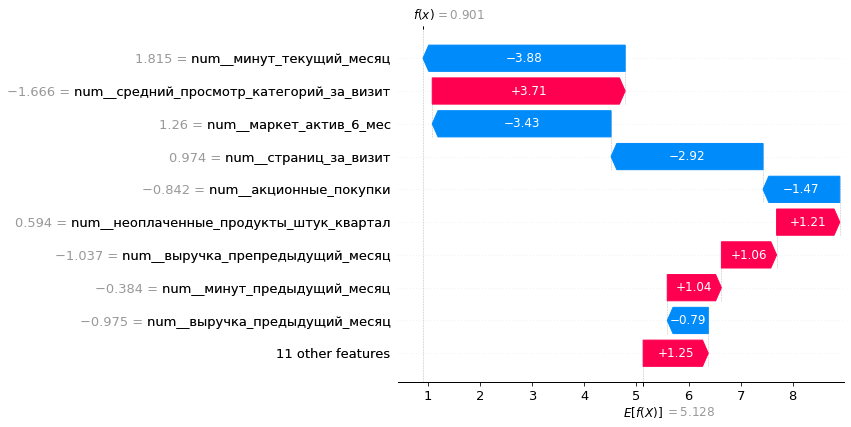

In [37]:
shap.plots.waterfall(shap_values[5])

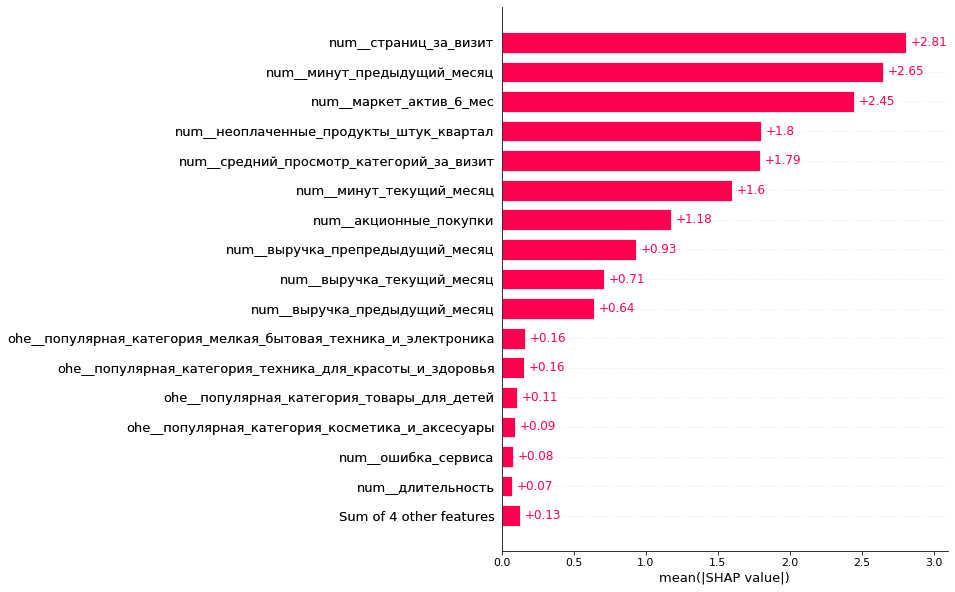

In [38]:
shap.plots.bar(shap_values, max_display=17) 

**Вывод**
Наиболее значемые признаки для модели это маркет_актив _6 _мес,  минут_предыдущий месяц_месяц, а также страниц_за_визит

## Сегментация покупателей

Выполните сегментацию покупателей. Используйте результаты моделирования и данные о прибыльности покупателей.Выберите группу покупателей и предложите, как увеличить её покупательскую активность.

In [39]:
X_train, X_proba, y_train, y_test = train_test_split(
    df.drop(['покупательская_активность'], axis=1),
    df['покупательская_активность'],
    test_size = TEST_SIZE, 
    random_state = RANDOM_STATE,
    stratify = df['покупательская_активность'])

In [40]:
df_money_mean.head()

,id,прибыль
1,215349,4.16
2,215350,3.13
3,215351,4.87
4,215352,4.21
5,215353,3.95


In [41]:
segment = X_proba.copy()
segment['вероятность_снижения_активности'] = y_test_pred[:, 1].copy()
segment = segment.merge(df_money_mean, on='id')

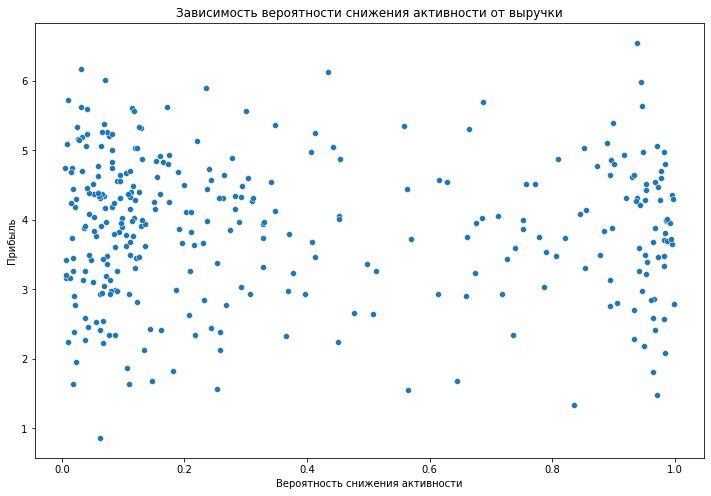

In [42]:
fig = plt.figure(figsize=(12,8))
sns.scatterplot(data=segment, y='прибыль', x='вероятность_снижения_активности')
plt.xlabel('Вероятность снижения активности')
plt.ylabel('Прибыль')
plt.title('Зависимость вероятности снижения активности от выручки')
plt.show()

In [43]:
segment['акционные_покупки_кат'] = segment['акционные_покупки'].apply(
lambda x: 'частая_акционная_покупка' if x>=0.5 else 'редкая_акционная_покупка')

In [44]:
segment.sample(10)

,id,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,выручка_предыдущий_месяц,выручка_препредыдущий_месяц,выручка_текущий_месяц,минут_предыдущий_месяц,минут_текущий_месяц,вероятность_снижения_активности,прибыль,акционные_покупки_кат
37,215953,стандарт,да,4.1,3,681,0.21,техника_для_красоты_и_здоровья,2,2,3,8,4838.0,4690.0,4839.3,17,16,0.202265,4.11,редкая_акционная_покупка
158,216441,стандарт,нет,4.1,4,136,0.30,мелкая_бытовая_техника_и_электроника,3,4,3,10,4356.0,4485.0,4374.2,20,14,0.106133,1.87,редкая_акционная_покупка
120,215883,стандарт,да,4.0,4,852,0.13,товары_для_детей,3,0,6,7,5173.0,5303.0,5416.1,18,6,0.185661,2.99,редкая_акционная_покупка
169,215817,стандарт,да,3.3,4,320,0.28,домашний_текстиль,5,4,3,13,5945.0,5444.0,6509.2,16,10,0.143874,2.43,редкая_акционная_покупка
123,216050,стандарт,нет,5.1,3,613,0.27,домашний_текстиль,4,1,3,12,5556.5,5573.0,5672.2,14,16,0.039660,5.06,редкая_акционная_покупка
288,216074,премиум,да,3.7,3,828,0.14,товары_для_детей,3,3,3,7,5094.0,5362.0,5456.7,18,12,0.235648,5.90,редкая_акционная_покупка
53,215864,стандарт,да,5.8,4,490,0.16,мелкая_бытовая_техника_и_электроника,2,4,5,16,4978.0,4774.0,5284.8,11,12,0.089431,2.97,редкая_акционная_покупка
142,216225,премиум,да,3.8,5,958,0.14,товары_для_детей,5,3,5,10,5874.0,5475.0,5658.2,12,18,0.097880,4.02,редкая_акционная_покупка
45,215938,стандарт,да,5.2,3,591,0.18,техника_для_красоты_и_здоровья,2,1,4,17,5922.5,4439.0,7338.2,15,13,0.037559,2.59,редкая_акционная_покупка
208,216370,стандарт,нет,5.2,4,717,0.13,кухонная_посуда,2,3,5,9,5767.0,5035.0,6531.4,15,10,0.210792,4.12,редкая_акционная_покупка


In [45]:
segment1 = segment.query('прибыль >= 3 \
                         and вероятность_снижения_активности >= 0.7 \
                         and акционные_покупки_кат == "частая_акционная_покупка"').copy()


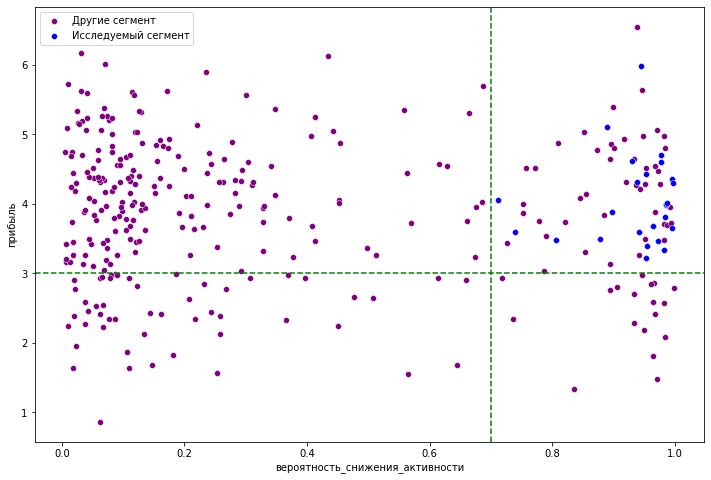

In [46]:
fig = plt.figure(figsize=(12,8))

sns.scatterplot(data=segment, y='прибыль',
                x='вероятность_снижения_активности',
                label='Другие сегмент', 
                color='purple')
sns.scatterplot(data=segment1, y='прибыль',
                x='вероятность_снижения_активности',
                label='Исследуемый сегмент', 
                color='blue')

plt.legend()
plt.axvline(x=0.7, color='green', linestyle='--')
plt.axhline(y=3, color='green', linestyle='--')
plt.show()

**Вывод:** Произведена маркировка пользователей, которые приносят прибыль больше 3, а также включающие в себя высокую вероятность снижения активности свыше 70%

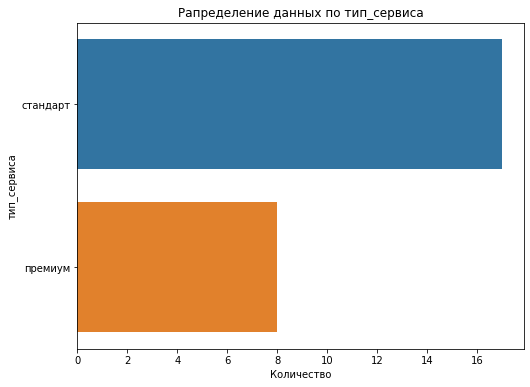

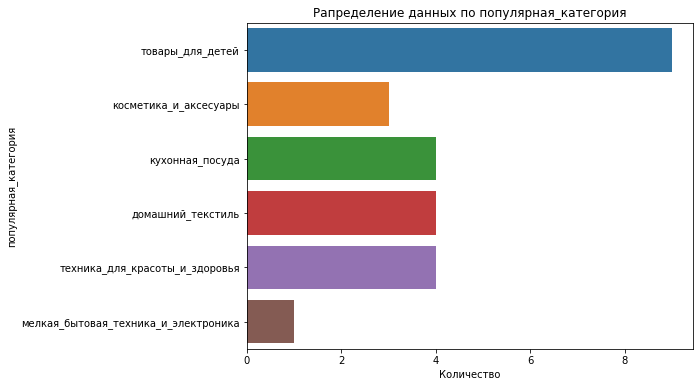

In [47]:
for i in segment1[['тип_сервиса', 'популярная_категория']].columns:
    plt.figure(figsize=(8,6))
    ax=sns.countplot(y=i, data=segment1)
    ax.set_title(f'Рапределение данных по {i}')
    ax.set_xlabel('Количество')
    plt.show()

**Вывод:** 
Наиболее популярная категория у пользователей с частой акционной покупкой это товары_для_детей

In [48]:
segment['сегмент'] = 'другие_сегменты'
segment.loc[segment['id'].isin(segment1['id']), 'сегмент'] = 'исследуемый_сегмент'

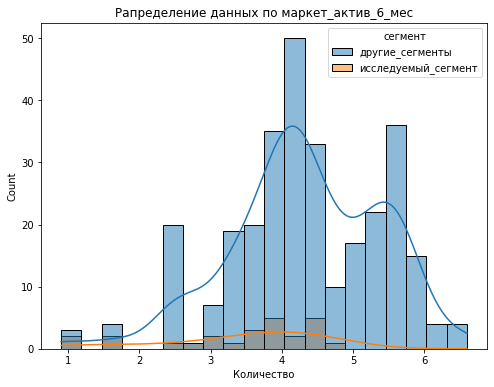

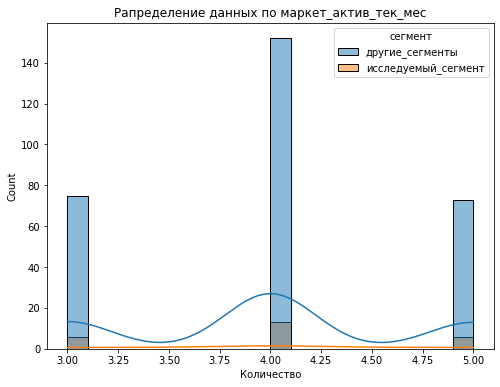

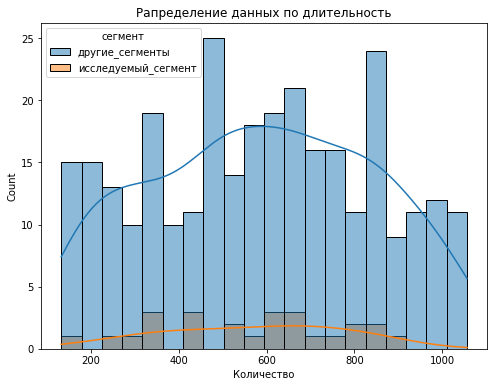

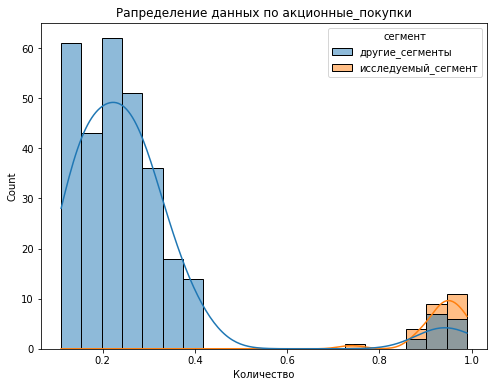

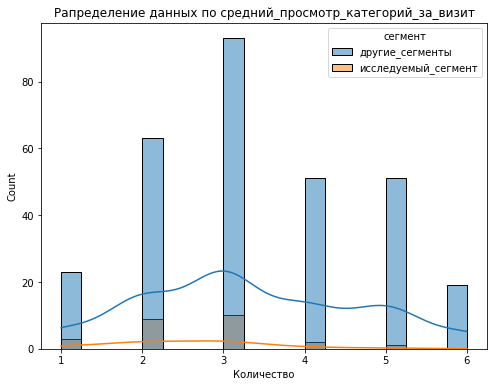

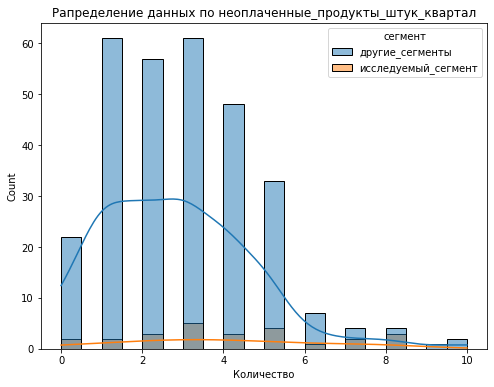

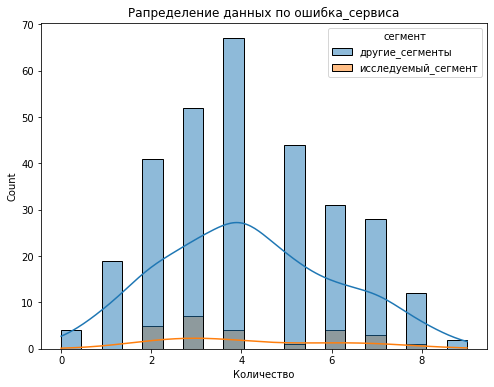

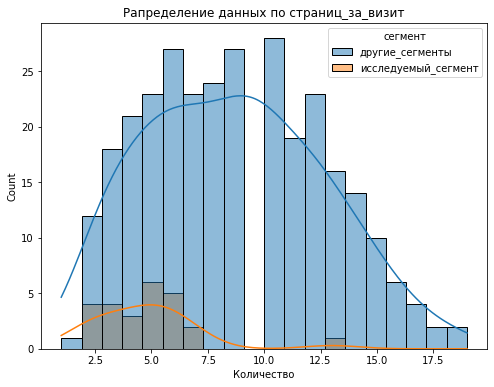

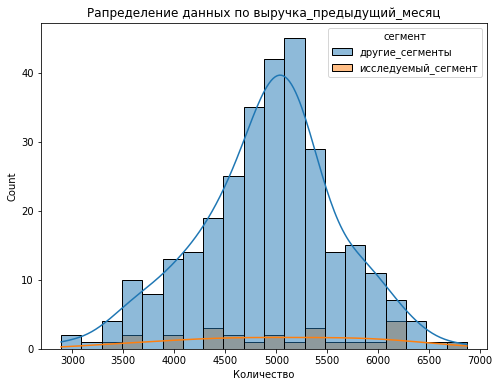

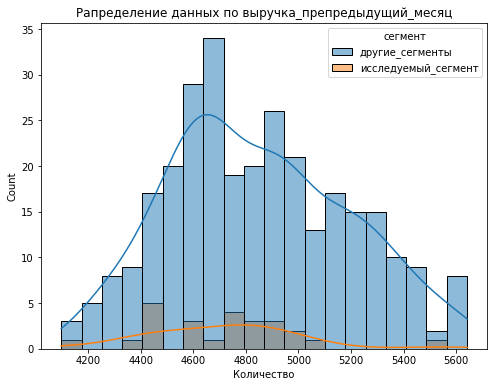

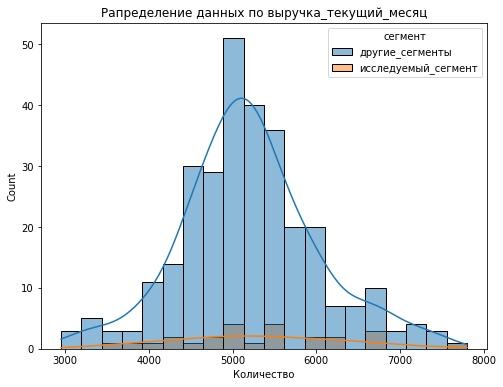

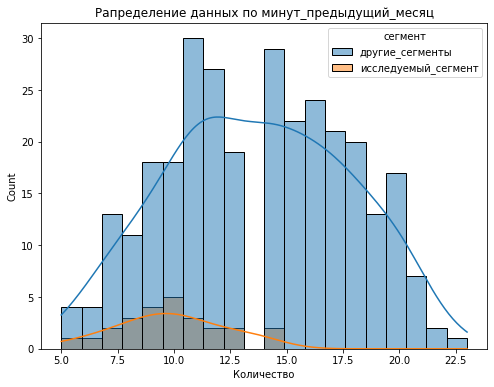

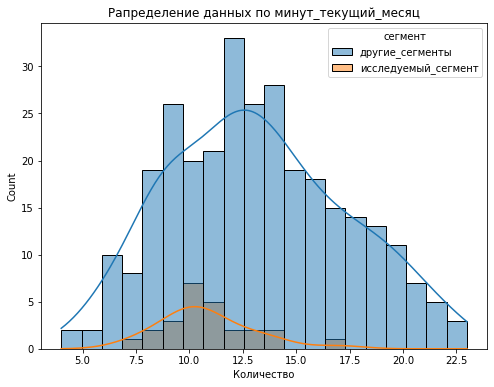

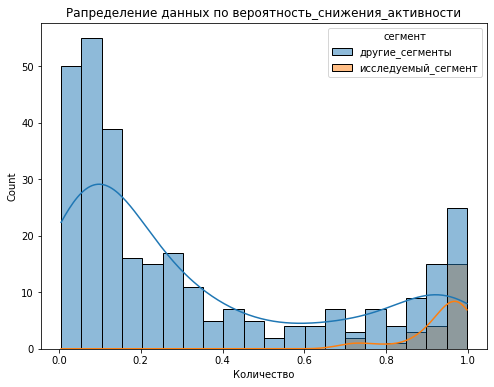

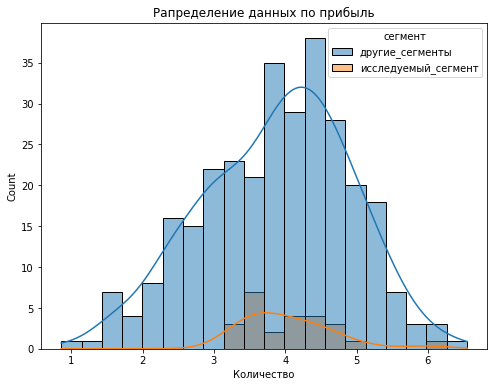

In [49]:
for i in segment.drop('id', 1).select_dtypes(include='number').columns:
    plt.figure(figsize=(8,6))
    ax = sns.histplot(segment, bins=20, kde=True, hue='сегмент', x=i)
    ax.set_title(f'Рапределение данных по {i}')
    ax.set_xlabel('Количество')
    plt.show()

**Вывод:** Пользователи покупающие большую часть товаров по акции, а также более склонные к снижению покупательской активности, как правило меньше проводят времени на сайте, также количество просматриваемых страниц у них ниже. Необходимо данных покупателей запоминать по id и выдавать нужные им поисковые страницы, что может повысить покупательскую активность


##  Общий вывод

Во время предобработки данных, небыло обнаружено пропусков и дубликатов в днанных. Были найдены и исправлены опичатки в категориальных данных, а также было убрано анамальное значение в маркет актив текущий месяц.

Исследовательский анализ показал, что наиболее популярен стандартный тип сервиса. Среднее посещение страниц за визит состовляет от 5 до 11.

Кореляционный анализ показал, что с целевым параметром наиболее корелирует значение страниц_за_визит. Мультиколинеарности между входными параметрами не обнаружено.

Наиболее точная модель стала  SVC с коэфициентом С=3, её точность на тестовых данных состовляет 92%. При проверке важности признаков, главными признаками были выбраны маркет_актив _6 _мес, минут_предыдущий месяц_месяц, а также страниц_за_визит.

Была проведена сегментация покупателей, где выяснилось что для повышения покупательской активности, следует отпровлять специальные предложения тем пользователям, кто склонен покупать товары для детей по акциям.

Для повышения точности предсказания модели и повышения покупательской активности необхадимо дополнить данные теми пользователями, кто склонен покупать товары по акции